# This is a first working example of the new code structure
it defines two components, that are both affected by a flux that defines a simple linear growth rate

### what works:
- initializing multiple components from a simple base component, that interact
- initializing flux from base flux to interact with different components
- supporting higher dimensionality through m.Arrays of State Variables, Intermediates and Equations (not yet fully tested though)
- solving using GEKKO as a backend
- repackaging output in Components (i.e. returned as properly labeled xarray dataset)

### what would be nice to have:
- providing a more sensible xsimlab process interface (alternatives to run_step to solve etc.)
- utilizing xsimlab functions instead of the custom GekkoContext defaultdicts, to pass variables and fluxes (not sure if possible)
- providing a choice between explicit time steps and integration via GEKKO
- generally providing a cleaner interface for xsimlab and gekko, without hiding too much functionality of either

BUT, at least the current structure should be good enough to write up my model examples for the publication.

### what I am trying to work out now:
- supplying external forcing to equations (how to do this with GEKKO)
- cleaner code structure and base classes
- supplying parameters at the correct dimensionality (most likely needs initialisation processes)
- more complicated ecosystem model implementations (Working on the ZeroD_NPZD_Slab_model.ipynb currently)

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra
from phydra.processes.main import Time, Grid0D,Boundary0D
from phydra.processes.fluxes import Flux
from phydra.processes.components import Component
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve

from phydra.utility.xsimlabwrappers import phydra_setup, createMultiComp, specifyComps4Flux

In [3]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.57.g382fe4c.dirty


In [4]:
model = xs.Model({'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 'context':GekkoContext, 
                  'C1':createMultiComp(Component,'c1',5), 'C2':createMultiComp(Component,'c2',5),
                  'flux':specifyComps4Flux(Flux,'c1','c2'), 'solver':GekkoSolve})

model

<xsimlab.Model (8 processes, 9 inputs)>
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
context
C1
    init               [in]
C2
    init               [in]
flux
    destruction_c2     [in]
    conversion2_c2     [in]
    inputrate_c1       [in]
solver

In [5]:
model.index_vars 

[('time', 'time'), ('C1', 'index'), ('C2', 'index')]

In [6]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 150)),
        'C1':{'init':1}, 
        'C2':{'init':2}, #the way dims are handled need to be specified in each flux!
        
        'flux':{'inputrate_c1':0.1,
               'conversion2_c2':.5,
               'destruction_c2':0.1}
    },
    output_vars={
        'C1__output':None , 
        'C2__output':None 
    }
                 )

In [7]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Model Time
Initializing Gekko Context
Initializing component  c1
Initializing component  c2
Initializing Flux
Assembling equation for component  c1
Assembling equation for component  c2
SolveInit
Model context dict stores: dict_items([('shape', {'env': 1}), ('comp_dims', {'c1': 5, 'c2': 5})])
ModelSolve done
Storing output component  c1
Storing output component  c2


In [11]:
print(out_ds)

<xarray.Dataset>
Dimensions:               (c1: 5, c2: 5, clock: 2, time: 150)
Coordinates:
  * clock                 (clock) int64 0 1
  * time                  (time) int64 0 1 2 3 4 5 6 ... 144 145 146 147 148 149
Dimensions without coordinates: c1, c2
Data variables:
    C1__init              int64 1
    C1__output            (c1, time) float64 1.0 0.7333 0.5556 ... 0.4 0.4 0.4
    C2__init              int64 2
    C2__output            (c2, time) float64 2.0 2.152 2.208 ... 2.0 2.0 2.0
    flux__conversion2_c2  float64 0.5
    flux__destruction_c2  float64 0.1
    flux__inputrate_c1    float64 0.1
    grid__length          int64 1
    grid__shape           int64 1
    ibcs__ibc             float64 nan
    index                 (c1) <U4 'c2-0' 'c2-1' 'c2-2' 'c2-3' 'c2-4'
    time__days            (time) int64 0 1 2 3 4 5 6 ... 144 145 146 147 148 149


#### The process Flux mimics a 'chemostat'
1. constant influx to c1
2. a rate of conversion to c2
3. a density dependent linear mortality of c2

Parameterisation of flux creates a gradient of the influx rate, that differentiates the 5 instances of each component $c1_{i}$

## Equations:

The 'Nutrient':

$$\frac{d \ c1_{i}}{dt}=influx_{i} - conversion * c2_{j}$$

The 'Organism':

$$\frac{d \ c2_{j}}{dt}=conversion * c2_{j} - destruction * c2_{j}$$

the dimensionality here defines 5 nutrient sources that are fed on by 5 organisms seperately, more complicated interactions are easily implemented in the specific flux

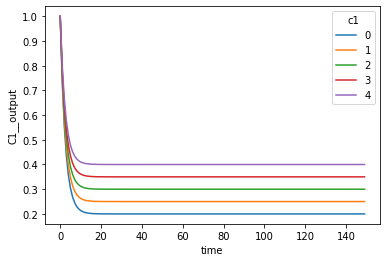

In [9]:
out_ds.C1__output.set_index(time='time').plot.line(x='time')

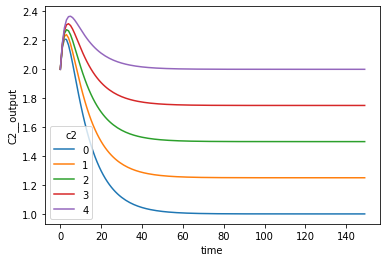

In [10]:
out_ds.C2__output.set_index(time='time').plot.line(x='time')